##### [Draft Express Combine Measurements](http://www.draftexpress.com/nba-pre-draft-measurements/2017/NBA+Draft+Combine/all/all/1/height/desc)

In [17]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import re

In [18]:
# Download HTML and create Beautiful Soup object
url = "http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine"

response = requests.get(url)
html = response.content

soup = bs(html, 'lxml')

In [19]:
# Find all of the links to the various pages
page_nums = soup.findAll('a', string=re.compile('\d'))

# Create list of page labels that aren't the starting page
start_nums = []
for p in page_nums:
    start_nums.append(int(p.string))

print(start_nums)
                      

[2, 3, 4, 5, 6]


In [20]:
# The part of the url that doesn't change from page to page
url_base = 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all'

# Create list of page urls
pages = [url_base]
for num in start_nums:
    pages.append(url_base + '/' + str(num))

print(pages)

['http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/2', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/3', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/4', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/5', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/6']


In [21]:
# Retrieve data table from starting pages
table = soup.find('table', attrs={'class': 'sorttable'})

In [22]:
# Create list of column headers
df_headers = []
for item in table.findAll('th'):
    #only include headers that don't contain sub categories
    if item.has_attr("rowspan") and item.get("rowspan") == "2":
        df_headers.append(item.string.strip())

        
# I had to hard code the columns that contain sub categories 
# i.e. height -> no shoes, shoes; vertical -> max, max reach, no, step, no step reach; hand -> length, width
# Set desired start indices for sub categories in list of column headers
height_IDX = 3   
vertical_IDX = 7
hand_IDX = 13


for i in range(len(table.findAll('tr')[1].findAll('th'))):
    item = table.findAll('tr')[1].findAll('th')[i].string.strip()
    
    if i in range(0,2):
        df_headers.insert(height_IDX, item)
        height_IDX += 1
    elif i in range(2,6):
        df_headers.insert(vertical_IDX, item)
        vertical_IDX += 1
    else:
        df_headers.insert(hand_IDX, item)
        hand_IDX += 1
        
print(df_headers)

['Player', 'Year', 'Draft pick', 'No Shoes', 'With Shoes', 'Wingspan', 'Standing reach', 'Max', 'Max Reach', 'No Step', 'No Step Reach', 'Weight', 'Body Fat', 'Length', 'Width', 'Bench', 'Agility', 'Sprint']


In [23]:
# Create dictionary from headers list: one for containing data; the other for containing index reference
df_dict = {}
df_idx_ref = {}
idx = 0

for name in df_headers:
    df_dict[name] = []
    df_idx_ref[idx] = name
    idx += 1
    

print("df_dict: {}\n".format(df_dict))
print("df_idx_ref: {}".format(df_idx_ref))

df_dict: {'Player': [], 'Year': [], 'Draft pick': [], 'No Shoes': [], 'With Shoes': [], 'Wingspan': [], 'Standing reach': [], 'Max': [], 'Max Reach': [], 'No Step': [], 'No Step Reach': [], 'Weight': [], 'Body Fat': [], 'Length': [], 'Width': [], 'Bench': [], 'Agility': [], 'Sprint': []}

df_idx_ref: {0: 'Player', 1: 'Year', 2: 'Draft pick', 3: 'No Shoes', 4: 'With Shoes', 5: 'Wingspan', 6: 'Standing reach', 7: 'Max', 8: 'Max Reach', 9: 'No Step', 10: 'No Step Reach', 11: 'Weight', 12: 'Body Fat', 13: 'Length', 14: 'Width', 15: 'Bench', 16: 'Agility', 17: 'Sprint'}


In [24]:
# Go through each page to populate df_dict
for page in pages:
    
    url = page
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    table = soup.find('table', attrs={'class': 'sorttable'})

    # Populate df_dict with corresponding data from each row
    rows = table.findAll('tr')[2:]

    for row in rows:
        data = row.findAll('td')
        idx = 0
        for d in data:
            if d.has_attr('data-order'):
                if d.get('data-order').strip() in ['-1.0', '-1.00', '-']:
                    df_dict[df_idx_ref[idx]].append(None)
                else:
                    df_dict[df_idx_ref[idx]].append(round(float(d.get('data-order').strip()), 2))

            else:
                # Many columns don't contain data-order attribute
                # Need to convert data type for columns: max, max reach, no step, no step reach, body fat, bench, agility, sprint
                if idx in [7, 8, 9, 10, 12, 15, 16, 17] and d.text.strip() != '-':
                    df_dict[df_idx_ref[idx]].append(round(float(d.text.strip()),2))
                else:
                    if d.text.strip() == '-':
                        df_dict[df_idx_ref[idx]].append(None)
                    else:
                        df_dict[df_idx_ref[idx]].append(d.text.strip())
            idx += 1

In [25]:
# Print out first 5 entries for each key df_dict
for key in df_dict:
    print('{}: {}\n'.format(key, df_dict[key][0:5]))

Player: ['Hasheem Thabeet', 'Jordan Bachynski', 'Zhou Qi', 'Jonathan Jeanne', 'Rudy Gobert']

Year: ['2009', '2014', '2016', '2017', '2013']

Draft pick: ['2', None, '43', None, '27']

No Shoes: [85.25, 85.25, 85.25, 84.75, 84.5]

With Shoes: [86.5, 86.0, 86.25, 86.0, 86.0]

Wingspan: [90.25, 88.0, 91.75, 90.5, 92.5]

Standing reach: [113.0, 108.5, 112.5, 113.5, 115.0]

Max: [None, 33.0, 32.0, 31.5, 29.0]

Max Reach: [None, 141.5, 144.5, 145.0, 144.0]

No Step: [None, 29.0, 31.5, 29.0, 25.0]

No Step Reach: [None, 137.5, 144.0, 142.5, 140.0]

Weight: [267.0, 254.0, 218.0, 207.0, 238.0]

Body Fat: [6.7, 7.5, 4.9, 8.7, 4.4]

Length: [None, 9.25, 9.25, 9.5, 9.75]

Width: [None, 10.0, 9.5, 10.0, 10.0]

Bench: [None, None, None, None, 7.0]

Agility: [None, 12.15, 11.27, 12.61, 12.85]

Sprint: [None, 3.36, 3.46, 3.36, 3.57]



In [26]:
# Check to see that each column contains same number of entries
for key in df_dict:
    print("{}: {}".format(key,len(df_dict[key])))

Player: 517
Year: 517
Draft pick: 517
No Shoes: 517
With Shoes: 517
Wingspan: 517
Standing reach: 517
Max: 517
Max Reach: 517
No Step: 517
No Step Reach: 517
Weight: 517
Body Fat: 517
Length: 517
Width: 517
Bench: 517
Agility: 517
Sprint: 517


In [27]:
# Convert dictionary to dataframe
df = pd.DataFrame(df_dict, columns=df_dict.keys())


# If draft hasn't occurred, sort dataframe in alphabetical order based on player name
# Change by argument in sort_values from 'Player' to 'Draft Pick'
df = df.sort_values(by=['Year', 'Draft pick', 'Player']).reset_index(drop=True)


# Rename columns that are subcategories of Height, Vertical, or Hand on Draft Express
df = df.rename(columns= {
    'No Shoes': 'Height (No Shoes)',
    'With Shoes': 'Height (With Shoes)',
    'Max': 'Vertical (Max)',
    'Max Reach': 'Vertical (Max Reach)',
    'No Step': 'Vertical (No Step)',
    'No Step Reach': 'Vertical (No Step Reach)',
    'Length': 'Hand (Length)',
    'Width': 'Hand (Width)'
})

df.head()

,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,Blake Griffin,2009,1,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,Terrence Williams,2009,11,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,Gerald Henderson,2009,12,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,Tyler Hansbrough,2009,13,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,Earl Clark,2009,14,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35


In [28]:
# Get summary statistics of dataframe
round(df.describe(), 2)

,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
count,517.00,516.00,517.00,517.00,450.00,450.00,450.00,450.00,516.00,514.00,470.00,468.00,284.00,444.00,446.00
mean,77.61,78.90,82.50,103.28,35.14,138.17,29.58,132.62,214.83,7.21,8.73,9.40,10.24,11.33,3.30
std,3.29,3.28,3.94,4.90,3.56,4.27,3.05,4.64,24.68,2.48,0.47,0.73,4.94,0.56,0.13
min,68.25,69.50,70.00,88.50,25.00,125.50,22.50,119.00,149.00,3.20,7.50,7.00,1.00,10.07,3.01
25%,75.25,76.75,79.75,100.00,32.50,135.50,27.50,129.50,196.00,5.40,8.50,9.00,6.75,10.94,3.20
50%,77.75,79.00,82.50,103.50,35.00,138.50,29.50,133.00,213.50,6.60,8.75,9.50,10.00,11.26,3.28
75%,80.00,81.25,85.50,107.00,37.50,141.50,31.50,136.00,232.00,8.40,9.00,9.75,14.00,11.66,3.38
max,85.25,86.50,92.50,115.00,44.50,147.50,38.00,144.00,303.00,20.80,10.25,12.00,23.00,13.44,3.81


In [29]:
# Create csv file from dataframe
df.to_csv('nba_draft_combine_all_years.csv')

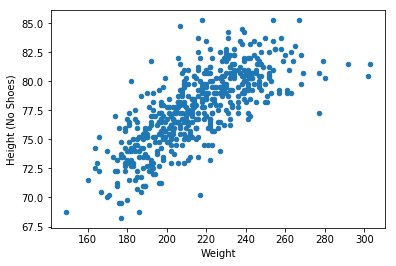

In [30]:
# Can now perform visualization and analysis on dataframe using matplotlib and pandas
import matplotlib.pyplot as plt
%matplotlib inline

# Simple scatter plot
df.plot.scatter('Weight', 'Height (No Shoes)');